# Wine Quality Prediction

## 1.Prerequisites 

Importing required libraries<br>
Read File

### Importing required libraries

In [74]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from collections import defaultdict

pd.set_option("display.max_columns",1000)

### Read File

In [75]:
df_master = pd.read_csv("Datasets/winequality-red.csv", header=0)
df_master.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [76]:
df_master.describe(include="all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [77]:
def fn_set_dtypes(df,categories_,ints_,floats_,objects_):
    for category_ in categories_:
        df[category_] = df[category_].astype("category")
        
    for int_ in ints_:
        df[int_] = df[int_].astype("int64")
        
    for float_ in floats_:
        df[float_] = df[float_].astype("float64")
        
    for object_ in objects_:
        df[object_] = df[object_].astype("object")
    return df

In [78]:
categories_=['quality']
floats_=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
ints_ = []
objects_ = []
df_master = fn_set_dtypes(df_master,categories_,ints_,floats_,objects_)
df_master.dtypes

fixed acidity            float64
volatile acidity         float64
citric acid              float64
residual sugar           float64
chlorides                float64
free sulfur dioxide      float64
total sulfur dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                 category
dtype: object

## 2. Data Cleaning and Preprocessing

Removing Duplicates <br>
Handling Missing Values <br>
Scaling Data


### Removing Duplicates

In [79]:
def fn_del_dup_cols(df):
    duplicated_df = df.copy()
    tot_rows = duplicated_df.shape[0]
    df.drop_duplicates(inplace=True)
    distinct_rows = df.shape[0]
    if(distinct_rows<tot_rows):
        print("Duplicates found. Total duplicates",tot_rows-distinct_rows)
    return duplicated_df,df

In [80]:
duplicated_df,df_master = fn_del_dup_cols(df_master)

Duplicates found. Total duplicates 240


### Handling Missing Values

In [81]:
def fn_trim_cols(df):
    clean_df = df.apply(lambda x: x.str.strip().replace('',np.nan) 
                        if x.dtype=="object"
                        else x)
    return clean_df

In [82]:
def fn_get_missing_vals(df):
    miss_val_cnts = df.isna().sum()
    miss_vals = miss_val_cnts[miss_val_cnts>0]
    return miss_vals

In [83]:
df_master=fn_trim_cols(df_master)
miss_vals = fn_get_missing_vals(df_master)
miss_vals

Series([], dtype: int64)

No Missing Values found.

### Scaling Data

In [84]:
def fn_minMax_scale(df,num_cols):
    scale_obj = {}
    scaled_num_features=[]
    for variable_ in num_cols:
        mx = MinMaxScaler()
        null_index=~df[variable_].isna()
        data_=df.loc[null_index,[variable_]]
        mx.fit(data_)
        df.loc[null_index,"minMax_"+variable_]=mx.transform(data_)
        scale_obj[variable_]=mx
        scaled_num_features.append("minMax_"+variable_)
    return df,scaled_num_features,scale_obj

In [85]:
df_master,scaled_mm_nums_,minMax_scale_obj = fn_minMax_scale(df_master,ints_+floats_)

In [86]:
df_master.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,minMax_fixed acidity,minMax_volatile acidity,minMax_citric acid,minMax_residual sugar,minMax_chlorides,minMax_free sulfur dioxide,minMax_total sulfur dioxide,minMax_density,minMax_pH,minMax_sulphates,minMax_alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0.247788,0.369863,0.00,0.061644,0.105175,0.169014,0.120141,0.567548,0.606299,0.137725,0.153846


In [87]:
df_master.describe(include="all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,minMax_fixed acidity,minMax_volatile acidity,minMax_citric acid,minMax_residual sugar,minMax_chlorides,minMax_free sulfur dioxide,minMax_total sulfur dioxide,minMax_density,minMax_pH,minMax_sulphates,minMax_alcohol
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.0,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,NaN,0.328371,0.280464,0.272333,0.111192,0.127085,0.209765,0.144261,0.487441,0.448651,0.196829,0.312664
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,NaN,0.153716,0.125364,0.195537,0.092624,0.082432,0.147145,0.118053,0.137219,0.122076,0.102196,0.166472
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,NaN,0.221239,0.184932,0.090000,0.068493,0.096828,0.084507,0.056537,0.406021,0.370079,0.131737,0.169231
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,NaN,0.292035,0.273973,0.260000,0.089041,0.111853,0.183099,0.113074,0.486784,0.448819,0.173653,0.276923
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,NaN,0.407080,0.356164,0.430000,0.116438,0.131886,0.281690,0.201413,0.569016,0.519685,0.239521,0.415385


## 3. EDA

Check for class imbalance

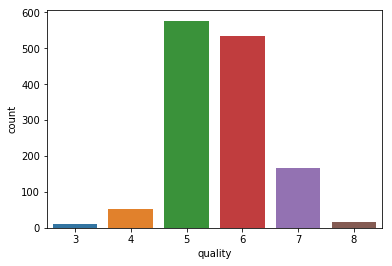

In [88]:
sn.countplot(x="quality",data=df_master)

In [89]:
def fn_get_class_dist(values):
    all_cat_dist={}
    cat_cnts = values.value_counts()
    cat_per = round(cat_cnts*100/sum(cat_cnts),2)
    for cat_ in cat_cnts.index:
        cat_dist={}
        cat_dist["Count"]=cat_cnts[cat_]
        cat_dist["Percentage"]=cat_per[cat_]
        all_cat_dist[cat_]=cat_dist
    return all_cat_dist

In [90]:
fn_get_class_dist(df_master["quality"])

{3: {'Count': 10, 'Percentage': 0.74},
 4: {'Count': 53, 'Percentage': 3.9},
 5: {'Count': 577, 'Percentage': 42.46},
 6: {'Count': 535, 'Percentage': 39.37},
 7: {'Count': 167, 'Percentage': 12.29},
 8: {'Count': 17, 'Percentage': 1.25}}

In [96]:
df_master["quality_3class"] = df_master["quality"].copy()
# ~df_master["quality"].isin([5,6])
df_master.loc[~df_master["quality"].isin([5,6]),"quality_3class"] = 3

In [98]:
df_master.describe(include="all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,minMax_fixed acidity,minMax_volatile acidity,minMax_citric acid,minMax_residual sugar,minMax_chlorides,minMax_free sulfur dioxide,minMax_total sulfur dioxide,minMax_density,minMax_pH,minMax_sulphates,minMax_alcohol,quality_3class
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.0,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577.0
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,NaN,0.328371,0.280464,0.272333,0.111192,0.127085,0.209765,0.144261,0.487441,0.448651,0.196829,0.312664,NaN
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,NaN,0.153716,0.125364,0.195537,0.092624,0.082432,0.147145,0.118053,0.137219,0.122076,0.102196,0.166472,NaN
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,NaN,0.221239,0.184932,0.090000,0.068493,0.096828,0.084507,0.056537,0.406021,0.370079,0.131737,0.169231,NaN
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,NaN,0.292035,0.273973,0.260000,0.089041,0.111853,0.183099,0.113074,0.486784,0.448819,0.173653,0.276923,NaN
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,NaN,0.407080,0.356164,0.430000,0.116438,0.131886,0.281690,0.201413,0.569016,0.519685,0.239521,0.415385,NaN


In [99]:
scaled_mm_nums_

['minMax_fixed acidity',
 'minMax_volatile acidity',
 'minMax_citric acid',
 'minMax_residual sugar',
 'minMax_chlorides',
 'minMax_free sulfur dioxide',
 'minMax_total sulfur dioxide',
 'minMax_density',
 'minMax_pH',
 'minMax_sulphates',
 'minMax_alcohol']

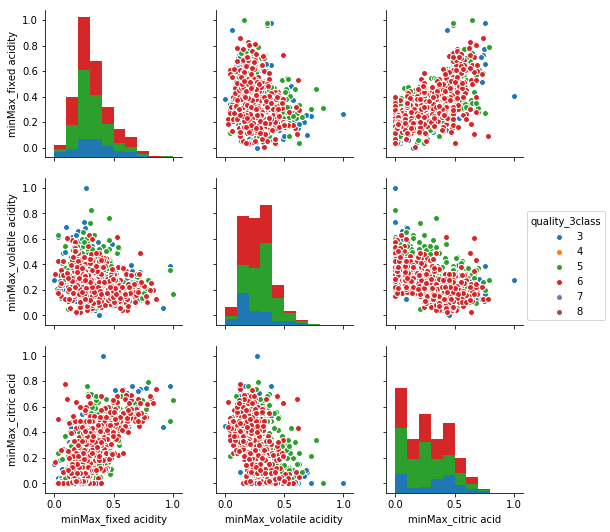

In [100]:
sn.pairplot(df_master,vars=['minMax_fixed acidity', 
                            'minMax_volatile acidity',
                            'minMax_citric acid'],hue='quality_3class')

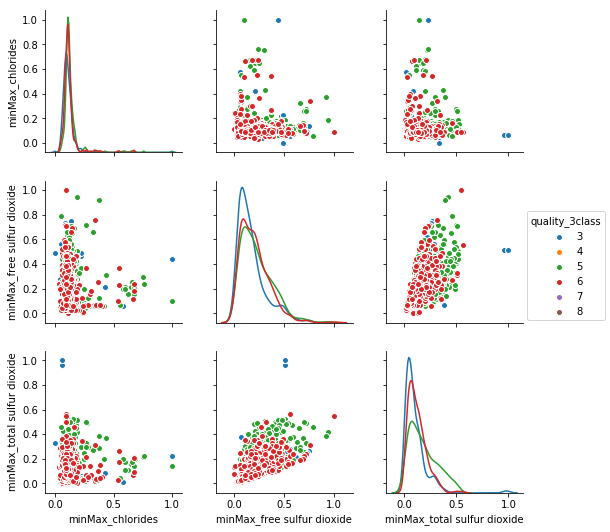

In [103]:
sn.pairplot(df_master,vars=['minMax_chlorides',
 'minMax_free sulfur dioxide',
 'minMax_total sulfur dioxide'],hue='quality_3class',diag_kind='kde')

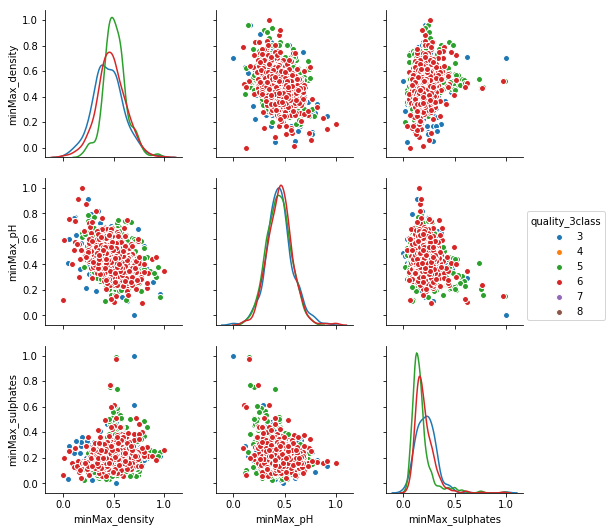

In [104]:
sn.pairplot(df_master,vars=['minMax_density',
 'minMax_pH',
 'minMax_sulphates'],hue='quality_3class',diag_kind='kde')